In [ ]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline, DistilBertTokenizerFast, DistilBertForSequenceClassification
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

# 1. Load your dataset
df = pd.read_csv("headlines.csv")

In [ ]:

# 2. Clean and preprocess text
def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'\[[^\]]*\]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [ ]:



df['text'] = df['text'].apply(clean_text)
df['title'] = df['title'].apply(clean_text)

In [ ]:
df.head(20)

,title,text,subject,date,target
0,GERMAN RESIDENTS FIGHT BACK: Anti-Islamic Song...,Apparently these Germans are not interested in...,left-news,"Jan 3, 2016",1
1,(VIDEO) BRAVO! TV HOST SCORCHES OBAMA FOR HIS ...,I VE HAD IT!,politics,"Jul 20, 2015",1
2,Greek president tells Turkey's Erdogan no trea...,ATHENS (Reuters) - Greek President Prokopis Pa...,worldnews,"December 7, 2017",0
3,Colbert Scorches Trump’s Anti-Trans Bigotry; I...,"During his campaign, Donald Trump promised tha...",News,"February 24, 2017",1
4,"Pentagon chief, Saudi deputy crown prince disc...",WASHINGTON (Reuters) - U.S. Defense Secretary ...,politicsNews,"March 16, 2017",0
5,Meet The ‘Responsible Gun Owner’ Who Was Shot ...,Meet Florida resident Jamie Gilt. Everyone say...,News,"March 9, 2016",1
6,What’s the Leading Killer of American Adults U...,"21st Century Wire says Last April, the UN gene...",Middle-east,"June 8, 2017",1
7,More than 60 Rohingya feared drowned as U.S. s...,"COX S BAZAR, Bangladesh/UNITED NATIONS (Reuter...",worldnews,"September 29, 2017",0
8,Trump will not visit FBI headquarters: MSNBC,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"May 11, 2017",0
9,Louisiana Cop Claims Murdering A 6-Year Old Ch...,A Louisiana deputy city marshal is in hot wate...,News,"September 23, 2016",1


In [ ]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
import torch

# 3. Summarize articles using BART
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6", device=-1 if not torch.cuda.is_available() else 0) # Force CPU if GPU is not available
# Define summarize function
def summarize(text):
    # Adjust max_length to avoid exceeding model's input limit
    max_tokens = 512  # Adjust as per model's limitations, default is 1024
    text_tokens = text.split()
    if len(text_tokens) < 130:
        return text
    truncated_text = " ".join(text_tokens[:max_tokens]) # Truncate long texts
    # Handle potential errors using try-except
    try:
        return summarizer(truncated_text, max_length=130, min_length=30 , do_sample=False)[0]['summary_text']
    except RuntimeError as e:
        # print(f"Error summarizing: {e}, Text: {text[:50]}")
        return "" # or some default value

Device set to use cuda:0


In [ ]:
from tqdm.notebook import tqdm
import pandas as pd # Import pandas if not already imported
# Apply tqdm to pandas to allow for progress bar in df.apply
tqdm.pandas()

df['summary'] = df['text'].progress_apply(summarize)

  0%|          | 0/44898 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1048 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
df.head(5)

,title,text,subject,date,target,summary
0,Greens hold out on climate in German coalition...,BERLIN (Reuters) - Environmental policy domina...,worldnews,"November 13, 2017",0,Greens are holding out for carbon dioxide emi...
1,U.S cautions citizens of possible unrest durin...,BAGHDAD (Reuters) - The U.S. embassy in Iraq c...,worldnews,"September 24, 2017",0,BAGHDAD (Reuters) - The U.S. embassy in Iraq c...
2,The NRA Just Mocked Kim Kardashian After She W...,Kim Kardashian West just went through a hellis...,News,"October 3, 2016",1,Kim Kardashian West was robbed of millions of...
3,Trump Has Been Financing The ‘Crown Jewel’ Of ...,Trump bashes China so much and blames them for...,News,"March 8, 2016",1,A Trump-branded luxury apartment building in ...
4,Trump says 'We're going to Florida very soon',WASHINGTON (Reuters) - U.S. President Donald T...,worldnews,"September 10, 2017",0,WASHINGTON (Reuters) - U.S. President Donald T...


In [ ]:

# 4. Train/test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
train_df.head()

,title,text,subject,date,target,summary
36335,Paul Ryan Responds To Trump’s ‘Loyalty’ Reques...,Donald Trump has brought more corruption into ...,News,"June 8, 2017",1,
12384,Senate confirms retired generals as first two ...,WASHINGTON (Reuters) - The U.S. Senate confirm...,politicsNews,"January 20, 2017",0,
24419,Happy 4th Of July! American Income Inequality ...,As people head out to celebrate America s inde...,News,"July 4, 2016",1,
24740,Kurdistan rejects Iraq's demand to hand over a...,"ERBIL, Iraq (Reuters) - The Kurdistan Regional...",worldnews,"September 27, 2017",0,
27039,Factbox: International reaction to arrest of R...,"(Reuters) - Major governments, including the U...",worldnews,"December 26, 2017",0,


In [ ]:
test_df.head()

,title,text,subject,date,target,summary
22216,Thai tour guide arrested for inappropriate beh...,BANGKOK (Reuters) - Thai authorities have arre...,worldnews,"December 16, 2017",0,
27917,TRUMP SUPPORTERS Heckle Clinton Chairman: “We ...,Based #Trump supporters heckle @johnpodesta wh...,politics,"Oct 19, 2016",1,Based #Trump supporters heckle @johnpodesta wh...
25007,WILL AND GRACE Writers Explain How Their HATE ...,When Will & Grace creators David Kohan and Max...,left-news,"Sep 25, 2017",1,
1377,Russian bombers hit targets in Syria's Deir al...,MOSCOW (Reuters) - Six Russian long-range bomb...,worldnews,"December 1, 2017",0,MOSCOW (Reuters) - Six Russian long-range bomb...
32476,Man Caught Peeping On Little Boy In Airport Ba...,"According to Republicans, it is imperative tha...",News,"April 30, 2016",1,


In [ ]:
!pip install --upgrade tqdm --quiet # Upgrade tqdm to the latest version

import torch
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm  # Import tqdm

# 5. Cosine Similarity using Sentence-BERT
# Explicitly specify device as 'cpu' to avoid using GPU
device = torch.device('cpu')  # Or 'cuda' if you are sure your GPU and setup is correct
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

def cosine_sim(title, summary):
    emb1 = model.encode(title, convert_to_tensor=True)
    emb2 = model.encode(summary, convert_to_tensor=True)
    return util.cos_sim(emb1, emb2).item()

# Wrap the apply function with tqdm to display a progress bar
# Use tqdm with desc instead of description
# Accessing tuple elements using attribute names (e.g., row.title, row.summary)
train_df['cosine_score'] = [cosine_sim(row.title, row.summary) for row in tqdm(train_df.itertuples(), total=len(train_df), desc="Calculating Cosine Similarity (Train)")]
test_df['cosine_score'] = [cosine_sim(row.title, row.summary) for row in tqdm(test_df.itertuples(), total=len(test_df), desc="Calculating Cosine Similarity (Test)")]

cosine_threshold = train_df['cosine_score'].quantile(0.25)

def cosine_predict(score):
    return 0 if score < cosine_threshold else 1

test_df['cosine_pred'] = test_df['cosine_score'].apply(cosine_predict)

Calculating Cosine Similarity (Test): 100%|██████████| 8980/8980 [05:42<00:00, 26.20it/s]


In [ ]:
train_df.head()

,title,text,subject,date,target,summary,cosine_score
36335,Paul Ryan Responds To Trump’s ‘Loyalty’ Reques...,Donald Trump has brought more corruption into ...,News,"June 8, 2017",1,,0.140484
12384,Senate confirms retired generals as first two ...,WASHINGTON (Reuters) - The U.S. Senate confirm...,politicsNews,"January 20, 2017",0,,-0.017588
24419,Happy 4th Of July! American Income Inequality ...,As people head out to celebrate America s inde...,News,"July 4, 2016",1,,0.068606
24740,Kurdistan rejects Iraq's demand to hand over a...,"ERBIL, Iraq (Reuters) - The Kurdistan Regional...",worldnews,"September 27, 2017",0,,0.026520
27039,Factbox: International reaction to arrest of R...,"(Reuters) - Major governments, including the U...",worldnews,"December 26, 2017",0,,0.063258


In [ ]:
test_df.head()

,title,text,subject,date,target,summary,cosine_score,cosine_pred
22216,Thai tour guide arrested for inappropriate beh...,BANGKOK (Reuters) - Thai authorities have arre...,worldnews,"December 16, 2017",0,,0.026702,0
27917,TRUMP SUPPORTERS Heckle Clinton Chairman: “We ...,Based #Trump supporters heckle @johnpodesta wh...,politics,"Oct 19, 2016",1,Based #Trump supporters heckle @johnpodesta wh...,0.744555,1
25007,WILL AND GRACE Writers Explain How Their HATE ...,When Will & Grace creators David Kohan and Max...,left-news,"Sep 25, 2017",1,,0.084517,1
1377,Russian bombers hit targets in Syria's Deir al...,MOSCOW (Reuters) - Six Russian long-range bomb...,worldnews,"December 1, 2017",0,MOSCOW (Reuters) - Six Russian long-range bomb...,0.815389,1
32476,Man Caught Peeping On Little Boy In Airport Ba...,"According to Republicans, it is imperative tha...",News,"April 30, 2016",1,,0.067392,1


In [ ]:
print(cosine_threshold)

0.05056632962077856


In [ ]:


# 6. Naive Bayes similarity using embedding diff
train_diff = train_df.apply(lambda row: model.encode(row['title']) - model.encode(row['summary']), axis=1)
test_diff = test_df.apply(lambda row: model.encode(row['title']) - model.encode(row['summary']), axis=1)

X_train_nb = np.vstack(train_diff.values)
X_test_nb = np.vstack(test_diff.values)
y_train_nb = train_df['target'].astype(int)
y_test_nb = test_df['target'].astype(int)

scaler = StandardScaler()
X_train_nb_scaled = scaler.fit_transform(X_train_nb)
X_test_nb_scaled = scaler.transform(X_test_nb)

nb_model = GaussianNB()
nb_model.fit(X_train_nb_scaled, y_train_nb)
nb_pred = nb_model.predict(X_test_nb_scaled)

In [ ]:




# 7. DistilBERT for sequence classification
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = DistilBertTokenizerFast.from_pretrained(checkpoint)
bert_model = DistilBertForSequenceClassification.from_pretrained(checkpoint)

def predict_distilbert(title, summary):
    inputs = tokenizer(title, summary, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    logits = outputs.logits
    return torch.argmax(logits, dim=1).item()

test_df['distilbert_pred'] = test_df.apply(lambda row: predict_distilbert(row['title'], row['summary']), axis=1)

In [ ]:
test_df.head()

,title,text,subject,date,target,summary,cosine_score,cosine_pred,distilbert_pred
22216,Thai tour guide arrested for inappropriate beh...,BANGKOK (Reuters) - Thai authorities have arre...,worldnews,"December 16, 2017",0,,0.026702,0,0
27917,TRUMP SUPPORTERS Heckle Clinton Chairman: “We ...,Based #Trump supporters heckle @johnpodesta wh...,politics,"Oct 19, 2016",1,Based #Trump supporters heckle @johnpodesta wh...,0.744555,1,0
25007,WILL AND GRACE Writers Explain How Their HATE ...,When Will & Grace creators David Kohan and Max...,left-news,"Sep 25, 2017",1,,0.084517,1,1
1377,Russian bombers hit targets in Syria's Deir al...,MOSCOW (Reuters) - Six Russian long-range bomb...,worldnews,"December 1, 2017",0,MOSCOW (Reuters) - Six Russian long-range bomb...,0.815389,1,0
32476,Man Caught Peeping On Little Boy In Airport Ba...,"According to Republicans, it is imperative tha...",News,"April 30, 2016",1,,0.067392,1,0


--- Cosine Similarity ---
Accuracy: 0.6347
Precision: 0.6049
Confusion Matrix:
[[1638 2653]
 [ 627 4062]]



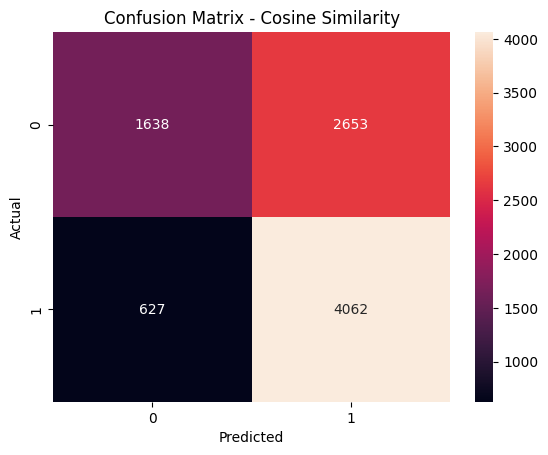

--- Naive Bayes ---
Accuracy: 0.7900
Precision: 0.7730
Confusion Matrix:
[[3126 1165]
 [ 721 3968]]



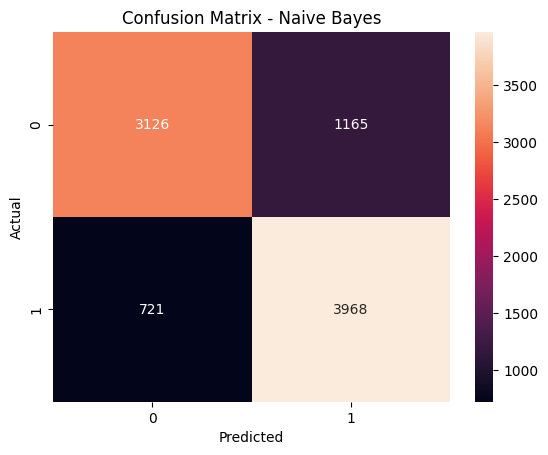

--- DistilBERT ---
Accuracy: 0.4586
Precision: 0.4647
Confusion Matrix:
[[2979 1312]
 [3550 1139]]



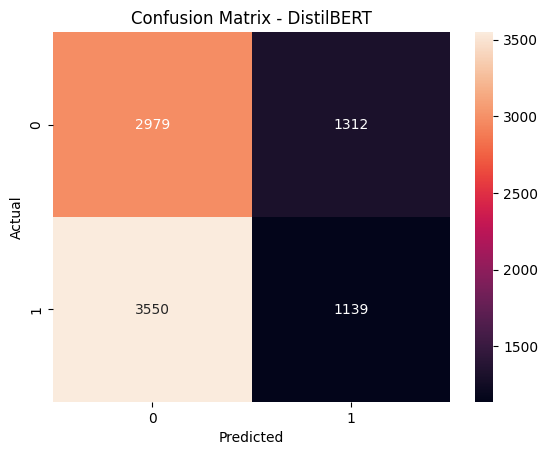

Cosine Similarity Threshold (auto-calculated): 0.0506


In [ ]:



# 8. Evaluation
def evaluate_model(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"--- {name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Confusion Matrix:\n{cm}\n")
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

y_true = test_df['target'].astype(int)
evaluate_model(y_true, test_df['cosine_pred'], "Cosine Similarity")
evaluate_model(y_true, nb_pred, "Naive Bayes")
evaluate_model(y_true, test_df['distilbert_pred'], "DistilBERT")

# Print thresholds
print(f"Cosine Similarity Threshold (auto-calculated): {cosine_threshold:.4f}")

In [ ]:
# Use training set to find the optimal threshold based on precision/recall trade-off
from sklearn.metrics import precision_recall_curve

# Assuming nb_probs is the output of the Naive Bayes model's predict_proba method
nb_probs = nb_model.predict_proba(X_train_nb_scaled)[:, 1]  # Get probabilities for the positive class

precisions, recalls, thresholds = precision_recall_curve(y_train_nb, nb_probs) # changed y_train to y_train_nb
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
nb_threshold = thresholds[np.argmax(f1_scores)]

In [ ]:
# 10. Print All Thresholds
print("\n--- Thresholds Used ---")
print(f"Cosine Similarity Threshold (auto-calculated): {cosine_threshold:.4f}")
print(f"Naive Bayes Threshold (auto-calculated): {nb_threshold:.4f}")
print(f"DistilBERT Threshold (default cutoff): 0.5000")
# Use training set to find the optimal threshold based on precision/recall trade-off
from sklearn.metrics import precision_recall_curve

# Assuming nb_probs is the output of the Naive Bayes model's predict_proba method
nb_probs = nb_model.predict_proba(X_train_nb_scaled)[:, 1]  # Get probabilities for the positive class

precisions, recalls, thresholds = precision_recall_curve(y_train_nb, nb_probs) # changed y_train to y_train_nb
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
nb_threshold = thresholds[np.argmax(f1_scores)]
print(f"\n[Cosine Similarity] Threshold (assumed): {cosine_threshold:.2f}")
print(f"[Naive Bayes] Threshold (calculated): {nb_threshold:.2f}")
print(f"[DistilBERT Classifier] Threshold (predicted probability cutoff): 0.5")




--- Thresholds Used ---
Cosine Similarity Threshold (auto-calculated): 0.0506
Naive Bayes Threshold (auto-calculated): 0.9859
DistilBERT Threshold (default cutoff): 0.5000

[Cosine Similarity] Threshold (assumed): 0.05
[Naive Bayes] Threshold (calculated): 0.99
[DistilBERT Classifier] Threshold (predicted probability cutoff): 0.5


<ipython-input-73-e3a4aac273ae>:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


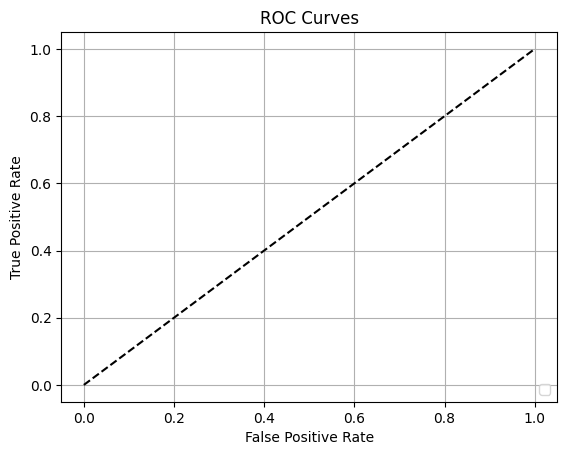

In [ ]:
# Plot ROC Curves
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# Bar chart for metric comparison
from sklearn.metrics import f1_score # Import f1_score
metrics_data = {
    "Model": ["Cosine", "Naive Bayes", "DistilBERT"],
    "Accuracy": [
        accuracy_score(y_true, test_df['cosine_pred']),
        accuracy_score(y_true, nb_pred),
        accuracy_score(y_true, test_df['distilbert_pred'])
    ],
    "Precision": [
        precision_score(y_true, test_df['cosine_pred']),
        precision_score(y_true, nb_pred),
        precision_score(y_true, test_df['distilbert_pred'])
    ],
    "F1 Score": [
        f1_score(y_true, test_df['cosine_pred']),
        f1_score(y_true, nb_pred),
        f1_score(y_true, test_df['distilbert_pred'])
    ]
}

metric_df = pd.DataFrame(metrics_data)

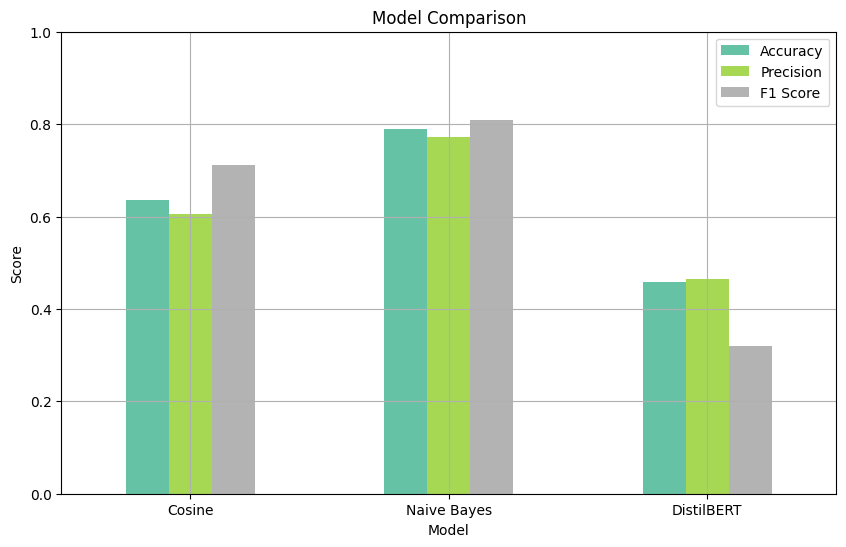

In [ ]:

# Plot bar chart
metric_df.set_index("Model").plot(kind="bar", figsize=(10, 6), colormap="Set2")
plt.title("Model Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(True)
plt.show()